# 05 - Analysis - Geothermal Probes: Inverted Density as Metric for Potential
### Author: Daniel Herrera-Russert
#### March 22, 2025

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pyproj import Transformer
import geohexgrid as ghg

## 1. Identifying High-Potential Areas  

To identify areas in the canton of Zürich that may still hold geothermal development potential, we base our approach on the spatial distribution of existing boreholes (Erdwärmesonden). The underlying assumption is that regions with fewer nearby probes are likely to have experienced less thermal stress and interference, and therefore present better conditions for future installations.

Initially, we considered dividing the canton into a uniform hexagonal grid and computing the average number of neighboring boreholes within a 100-meter radius from each cell's centroid. While this grid-based method offers a practical spatial discretization and allows for fast aggregation, it introduces artificial boundaries that may not align with the radial nature of subsurface thermal fields. It also relies on interpolation over space, rather than direct representation of borehole influence.

To address these limitations, we adopt a more physically grounded approach. Each borehole is represented by a circular buffer with a 100-meter radius, which approximates the typical extent of thermal influence underground. By drawing these buffer zones around all boreholes and analyzing their overlaps, we can directly observe zones of high or low spatial congestion. Areas where many buffers overlap can be interpreted as thermally saturated or overutilized, whereas regions with sparse or no buffer intersections may still be suitable for further development.

This method better preserves the continuous nature of spatial interference and provides a visually intuitive representation of borehole density. It also allows for future steps such as rasterizing the cumulative buffer overlaps or calculating inverse density measures to serve as a proxy for geothermal potential.

As with the other components of this project, such as the predictive model for yield estimation, this analysis is limited to the geographic extent of the available dataset. Boreholes located just beyond the administrative boundary of Zürich—especially in neighboring cantons—are not accounted for. This means that density values near the polygon edges may be underestimated due to missing data. These boundary effects should be kept in mind when interpreting results near the perimeter of the canton.

---

## 2. Assessing Density with 100-metre buffers

The choice of a 100-metre buffer radius is grounded in insights gained during the development of the predictive model. In the preprocessing phase, we evaluated the statistical impact of borehole proximity by calculating a normalized count of neighboring boreholes within varying radii for each installation. Using Ordinary Least Squares (OLS) regression, we assessed how these proximity-based metrics influenced energy yield.

The results indicated that the effect of thermal interference was most pronounced within a 100-metre radius. Beyond this distance, the impact on yield became statistically insignificant. As such, 100 metres was identified as the most relevant threshold for capturing horizontal thermal interaction.

Based on this finding, we adopt the same 100-metre radius for generating buffer zones around boreholes in our spatial analysis. These buffers serve as the foundation for computing an inverted density metric, which acts as a proxy for geothermal potential across the canton.

In [2]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_probes_with_density_elevation.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

# If CRS is missing or incorrect, explicitly set it to LV95
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.set_crs("EPSG:2056", allow_override=True)

In [3]:
# Load and ensure Zürich boundary is in LV95
boundary_gdf = gpd.read_file("../data/raw/zh_boundary.geojson").to_crs("EPSG:2056")

# Merge into single polygon
boundary_polygon = boundary_gdf.geometry.union_all()  # Returns a single shapely object

In [4]:
# Create 100m buffer around each borehole (geometry is in LV95 meters)
borehole_buffers = zh_geothermal_probes_gdf.copy()
borehole_buffers["buffer"] = borehole_buffers.geometry.buffer(100)

In [5]:
# Turn buffers into a GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(borehole_buffers.drop(columns="geometry"), 
                               geometry=borehole_buffers["buffer"], 
                               crs="EPSG:2056")

# Clip buffers to Zürich polygon to avoid overflow outside canton limits
buffer_gdf = gpd.clip(buffer_gdf, boundary_polygon)

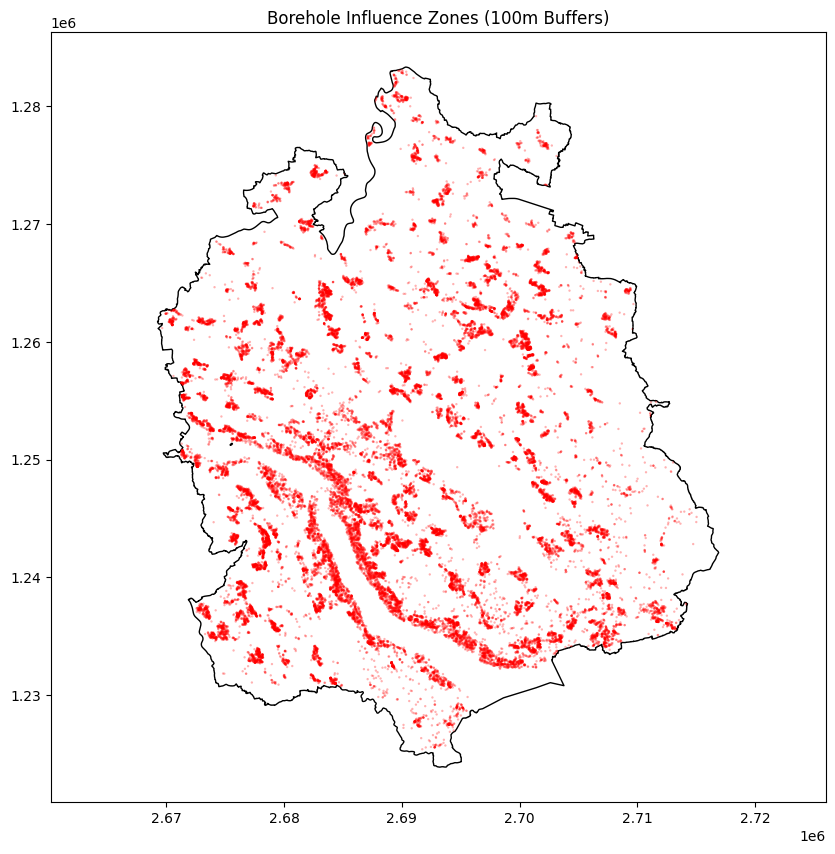

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot canton boundary
boundary_gdf.plot(ax=ax, color="none", edgecolor="black", linewidth=1)

# Plot buffer zones
buffer_gdf.plot(ax=ax, facecolor="red", alpha=0.3, edgecolor="none")

plt.title("Borehole Influence Zones (100m Buffers)")
plt.axis("equal")
plt.show()

### 2.1. Rethinking the Representation of Borehole Influence

While 100-meter buffer zones around individual boreholes are physically meaningful for modeling thermal interference, they become visually insignificant when viewed at the scale of the entire canton. In the map above, even areas of high borehole density appear sparse due to the limited visual footprint of each circle. This makes it difficult to intuitively assess geothermal potential through simple buffer plots.

Rather than relying on buffer size as a visual cue, a more effective approach is to count the number of overlapping buffers at each location. Regions where multiple 100-meter circles intersect indicate zones of high borehole density, which in turn implies greater thermal saturation and lower potential for new installations. By computing and visualizing these overlap counts, we can build a spatial density surface that inverts into a proxy for geothermal potential.

Although it might be tempting to increase the buffer size (e.g., 500 or 1000 meters) to enhance visibility at the regional scale, this would undermine the physical relevance of the model. Prior statistical testing using OLS regression during the enhancement of the dataset for the predictive model confirmed that a 100-meter radius provides the strongest explanatory power for geothermal yield. Thermal interference beyond this distance becomes negligible and is unlikely to influence system performance.

In light of this, we propose to retain the 100-meter radius for its technical validity, but shift the focus from visualizing raw buffer geometries to aggregating their overlaps. This can be achieved either through a vector-based hexagonal grid or a raster-based heatmap. In both cases, the output will allow us to meaningfully assess horizontal borehole density and derive an inverted metric of potential that is both visually interpretable and physically grounded.


---

## 3. Building a hexagonal Grid

A **hexagonal grid** is chosen for spatial analysis due to its advantages over traditional square grids, particularly in **radius-based queries** and **proximity modeling**. Unlike square grids, hexagons provide **equal distance to neighbors** and avoid directional bias, making them especially suitable for modeling **thermal interference** from geothermal boreholes. The grid will cover the **entire canton of Zürich**, with **parametric hex 

To simplify and enhance hex grid generation, we are now using the [geohexgrid](https://github.com/mrcagney/geohexgrid) Python library. This package allows for the creation of **seamless, correctly spaced, flat-topped hexagons** in a **projected coordinate system (LV95)**. Unlike manually calculated geometries or H3 indexing, `geohexgrid` enables precise control over hex size (e.g., 200 meters flat-to-flat) and outputs clean, clipped hexagons aligned to an arbitrary polygon.

**Challenges & Considerations**

1. **Boundary Handling:** The irregular shape of the canton means that edge-aligned hexagons may be **partially clipped**. We mitigate this by slightly **extending the grid generation bounds** to ensure full hex coverage around Zürich’s perimeter.
2. **Bordering Regions:** The dataset includes only boreholes located **within the canton of Zürich**. As a result, areas close to the boundary **do not account for boreholes in neighboring cantons**, which may lead to an **overestimation of potential** near the edges.
3. **Computational Load:** With over **36,000 boreholes**, spatial querying can be computationally intensive. To optimize performance, we use **GeoPandas' spatial indexing and joins**, and optionally **KDTree-based querying (from SciPy)** to efficiently aggregate borehole data per hexagon.

**Planned Workflow**

- **Hex Grid Generation:** Use `geohexgrid.make_grid_from_geom()` with a user-defined diameter (e.g., 200 meters) to generate a **flat-topped hexagonal grid** clipped to Zürich’s administrative boundary in LV95 (EPSG:2056).
- **Spatial Filtering:** Apply **GeoPandas' spatial clip** and joins to limit the hexagons to valid areas and associate boreholes with their containing hexes.
- **Density & Potential Mapping:** Count boreholes within each hex and compute **inverted density** as a proxy for **geothermal potential**—highlighting low-density zones with higher suitability.
- **Export Format:** Results will be **exported as GeoJSON**, allowing integration with GIS platforms, web maps, or further modeling steps.

This approach ensures both **spatial precision** and **analytical flexibility**, enabling meaningful visualization and decision support for shallow geothermal development across the canton.
 

In [7]:
# Get bounding box in LV95 (meters)
minx, miny, maxx, maxy = boundary_polygon.bounds
print(f"Bounding box (LV95): minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")

Bounding box (LV95): minx=2669244.8787363335, miny=1223895.6503310367, maxx=2716900.401939645, maxy=1283342.8674727087


In [8]:
# Transformer for coordinate conversion
to_wgs84 = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)
to_lv95 = Transformer.from_crs("EPSG:4326", "EPSG:2056", always_xy=True)

In [9]:
# Cover it minimally with hexagons of circumradius R meters
hex_gdf = ghg.make_grid_from_gdf(boundary_gdf, R=100)

In [10]:
output_path = "../data/transformed/hex_zh_empty.geojson"
hex_gdf.to_file(output_path, driver="GeoJSON")

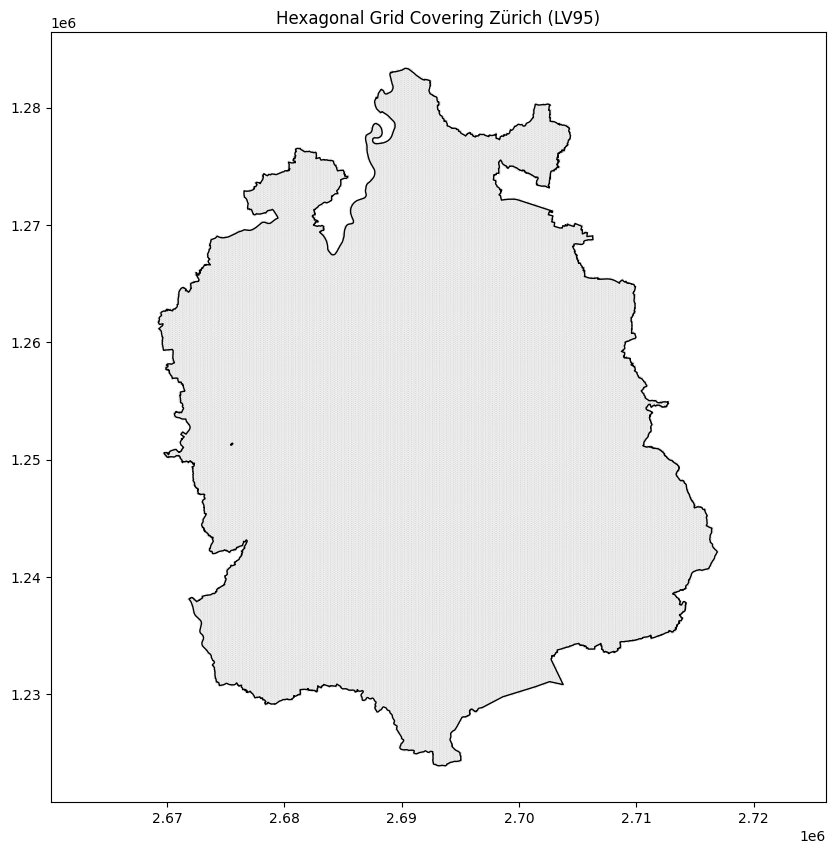

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

hex_gdf.plot(ax=ax, facecolor="grey", alpha=0.5, edgecolor="white")
boundary_gdf.plot(ax=ax, color="none", edgecolor="black", linewidth=1)

plt.title("Hexagonal Grid Covering Zürich (LV95)")
plt.axis("equal")
plt.show()

---

## 4. Assigning Density Metric to Hexagons

To estimate geothermal potential across the hexagonal grid, we use an inverted borehole density metric. The underlying assumption is that areas with a higher concentration of existing boreholes are more thermally saturated and therefore less suitable for new geothermal installations. Conversely, areas with few or no boreholes are considered to have higher potential, due to lower thermal interference and greater availability of undisturbed subsurface heat.

By using the 100m buffer zones, this approach reflects not just where boreholes are located, but where thermal influence zones intersect, providing a richer density measure than just point-based counting.

The potential score from 0 to 1 is later calculated using a simple formula: one divided by one plus the borehole count within each hexagon. This ensures that values range between zero and one. A hexagon with no boreholes receives a score of one, indicating the highest potential. As the number of boreholes increases, the score decreases accordingly. For example, a hex with three boreholes would have a potential score of 0.25, reflecting reduced suitability due to existing thermal load.

$$\text{potential\_score} = \frac{1}{1 + \text{borehole\_count}}$$

This inversion approach transforms borehole density into an interpretable metric of geothermal potential, where higher values correspond to lower borehole activity. The resulting scale is continuous and intuitive: values close to one represent optimal, underused areas, while values closer to zero indicate densely developed or saturated zones.

Although this metric does not directly account for subsurface thermal dynamics, it provides a practical and scalable approximation that supports decision-making in the early planning stages of shallow geothermal deployment.


In [12]:
# Ensure both GeoDataFrames use the same CRS
assert hex_gdf.crs == buffer_gdf.crs, "CRS mismatch!"

# Perform spatial join: each buffer gets matched to hex(es) it intersects
joined = gpd.sjoin(buffer_gdf[["geometry"]], hex_gdf[["geometry"]], predicate="intersects", how="left")

# Count number of buffers per hex (group by hex geometry)
buffer_counts = joined.groupby("index_right").size()

# Assign count back to hex_gdf
hex_gdf["borehole_density"] = hex_gdf.index.map(buffer_counts).fillna(0).astype(int)

In [13]:
# Invert the density — higher potential = lower borehole density
hex_gdf["potential_score"] = 1 / (1 + hex_gdf["borehole_density"])

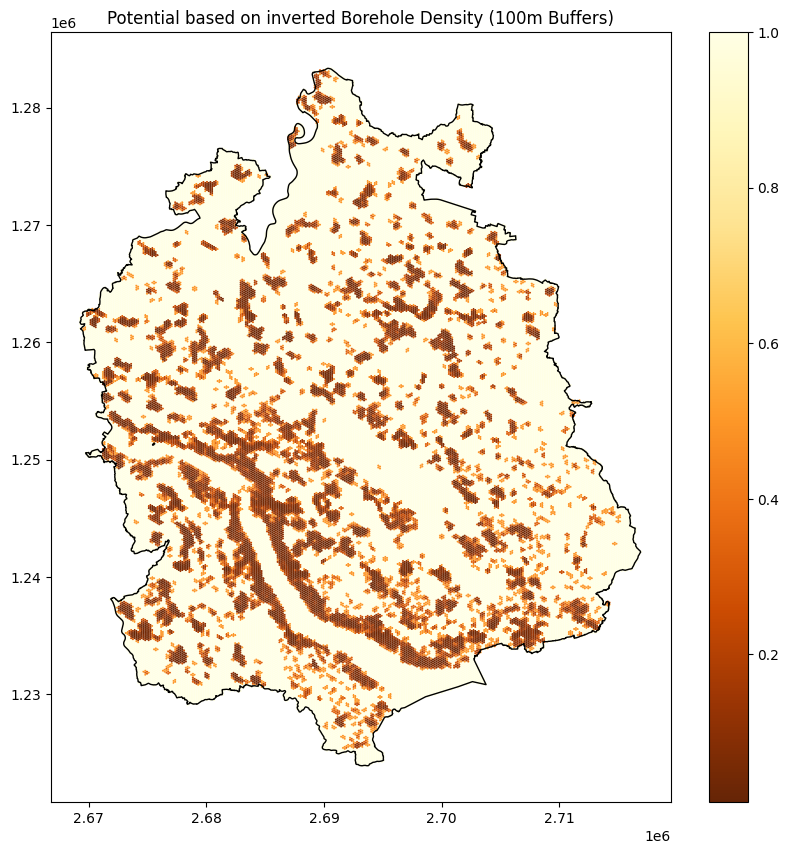

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

hex_gdf.plot(ax=ax, column="potential_score", cmap="YlOrBr_r", edgecolor="none", linewidth=0, legend=True)
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black")

plt.title("Potential based on inverted Borehole Density (100m Buffers)")
plt.axis("equal")
plt.show()

In [15]:
output_path = "../data/transformed/hex_inverted_density_potential.geojson"
hex_gdf.to_file(output_path, driver="GeoJSON")

---

In [16]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/hex_inverted_density_potential.geojson"
hex_gdf = gpd.read_file(geojson_path)

# If CRS is missing or incorrect, explicitly set it to LV95
hex_gdf = hex_gdf.set_crs("EPSG:2056", allow_override=True)

hex_gdf.head()

,cell_id,borehole_density,potential_score,geometry
0,"17954,14132",0,1.0,"POLYGON ((2693050 1223780.498, 2693150 1223780..."
1,"17956,14132",0,1.0,"POLYGON ((2693350 1223780.498, 2693450 1223780..."
2,"17958,14132",0,1.0,"POLYGON ((2693650 1223780.498, 2693750 1223780..."
3,"17952,14134",0,1.0,"POLYGON ((2692750 1223953.703, 2692850 1223953..."
4,"17953,14133",0,1.0,"POLYGON ((2692900 1223867.101, 2693000 1223867..."


In [17]:
hex_gdf["potential_score_fmt"] = hex_gdf["potential_score"].map(lambda x: f"{x:.2f}")

In [18]:
output_path = "../data/transformed/hex_inverted_density_potential.geojson"
hex_gdf.to_file(output_path, driver="GeoJSON")